In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import pandas as pd
from geopy.geocoders import Nominatim
from matplotlib.colors import SymLogNorm
from matplotlib.pyplot import cm

import xesmf as xe
#from pykrige.ok import OrdinaryKriging
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import dask
import utils


import cartopy.feature
from cartopy.mpl.patch import geos_to_path
import cartopy.crs as ccrs

import geopandas

In [2]:
## look at https://wedocs.unep.org/bitstream/handle/20.500.11822/11406/Pog_&amp;_iPog_-_Energy_and_Fuels.pdf?sequence=1&amp%3BisAllowed=

## for emissions factors scaling

## fix tott

## Set constants

In [3]:
coal_year_range = np.arange(0,41)
percents = [0, 10, 20,30,40,50,60, 70,80,90]
years = [0,10,20,30]
coal_year_range = np.arange(0,41)

In [4]:
## Add time dimension
length_simulation = 50*365

time_array = np.arange(0, length_simulation)

## Data read in

### Emissions dataframe

In [5]:
CGP_df = pd.read_csv('mod_coal_inputs/BC_limited_country_SEA_GAINS_Springer.csv')

In [6]:
CGP_df.columns = CGP_df.columns.str.replace(' ', '_')

In [7]:
CGP_df = CGP_df.rename(columns = {'YEAR':'Year_of_Commission', 'EMISFACTOR.PLATTS':'CO2_weighted_capacity_1000tonsperMW'})

loc_df = {}
mort_df = {}
for c in countries:
    #loc_df[c] = pd.DataFrame(columns = percents, index = coal_year_range)
    mort_df[c] = pd.DataFrame(columns = percents, index = coal_year_range)

    mask = country_mask.mask(ds, lon_name = 'lon', lat_name = 'lat')
    contiguous_mask = ~np.isnan(mask)& (mask == country_mask.map_keys(c))
    for yr in years:
        for pc in percents:
            #print(yr,pc)
            #loc_df[c][pc].loc[yr] = ds.where(contiguous_mask).weighted(ds_area['area']).mean(dim = ['lat','lon'])['BC_conc'].sel(year_shutdown = yr).sel(percent = pc).sum().values
            mort_df[c][pc].loc[yr] = ds.where(contiguous_mask).weighted(ds_area['area']).mean(dim = ['lat','lon'])['BC_conc'].sel(year_shutdown = yr).sel(percent = pc).sum().values

    #loc_df[c] = loc_df[c].astype('float32')
    mort_df[c] = mort_df[c].astype('float32')
    #loc_df[c].to_csv(f'Outputs/{c}_early_shutdown_co2pct_sum.csv')

loc_mean_df = {}
for c in countries:
    loc_mean_df[c] = pd.DataFrame(columns = percents, index = coal_year_range)
    mask = country_mask.mask(ds, lon_name = 'lon', lat_name = 'lat')
    contiguous_mask = ~np.isnan(mask)& (mask == country_mask.map_keys(c))
    for yr in years:
        for pc in percents:
            #print(yr,pc)
            loc_mean_df[c][pc].loc[yr] = ds.where(contiguous_mask).weighted(ds_area['area']).mean(dim = ['lat','lon'])['BC_conc'].sel(year_shutdown = yr).sel(percent = pc).mean().values
    loc_mean_df[c] = loc_mean_df[c].astype('float32')
    #loc_mean_df[c].to_csv(f'Outputs/{c}_early_shutdown_co2pct_mean.csv')

## Read in loc mean ds

In [8]:
loc_mean_df = {}

In [9]:
loc_mean_df['China'] = xr.open_dataset('Outputs/China_early_shutdown_co2pct_mean.nc')

In [10]:
loc_mean_df

{'China': <xarray.Dataset>
 Dimensions:        (year_shutdown: 4, percent: 1)
 Coordinates:
   * year_shutdown  (year_shutdown) int64 0 10 20 30
   * percent        (percent) int64 1
     raster         int32 ...
 Data variables:
     BC_conc        (percent, year_shutdown) float64 ...
     AF             (percent, year_shutdown) float64 ...
     delta_I        (percent, year_shutdown) float64 ...}

## Dataframe for total CO2 emitted under each scenario

In [10]:
#######in progress retiring by year after co2#########
def early_retirement_by_CO2_year(year_early, df, CO2_val, time_array, shutdown_years):
    ''' df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day'''
    min_comission_yr = df['Year_of_Commission'].min()
    #print(CO2_val)
    E = np.zeros(len(time_array))
        #print(year_comis)
    #print(CGP_op.loc[CGP_op.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
    test_array = np.where(time_array <= year_early, True, False)
    #plt.plot(test_array)
    E += test_array* df.loc[df.ANNUALCO2 >= CO2_val]['ANNUALCO2'].sum()
        #fig, ax = plt.subplots()
        #plt.plot(E[year])
    for year_comis in np.arange(min_comission_yr, df['Year_of_Commission'].max()):
        #print(year_comis)
        #print(df.loc[df.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
        test_array = np.where((time_array <= (year_comis-min_comission_yr) + shutdown_years), True, False)
        #print(test_array)
        #fig, ax = plt.subplots()
        #plt.plot(test_array* df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['BC_(g/day)'].sum())
        #print(CO2_val)
        #print(df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['ANNUALCO2'].sum())
        E += test_array* df.loc[(df.ANNUALCO2 < CO2_val) & (df.Year_of_Commission == year_comis)]['ANNUALCO2'].sum()
        #E[year] += (time_array>=0) * df.loc[df.CO2_weighted_capacity_1000tonsperMW < CO2_val]['BC_(g/day)'].sum()
        #plt.plot(E)

    
    return(E)



In [19]:
years_run = 50
coal_year_range = np.arange(0,41)

## Add time dimension
length_simulation = years_run
time_array = np.arange(0, length_simulation)

In [20]:
E_CO2_range_max_allyr = {}
for year in coal_year_range:
    E_CO2_range_max_allyr[year] = {}
    for r in np.arange(1,101):
        E_CO2_range_max_allyr[year][r] = early_retirement_by_CO2_year(year, CGP_df, np.percentile(CGP_df['ANNUALCO2'].dropna(),r), time_array, 40) # was CO2_weighted_capacity_1000tonsperMW but now annual
        E_CO2_range_max_allyr[year][r] = E_CO2_range_max_allyr[year][r].sum()

In [21]:
CO2_df = pd.DataFrame(E_CO2_range_max_allyr).T

In [22]:
d = dict(zip(CO2_df.columns, np.arange(0,101)[::-1]))
CO2_df = CO2_df.rename(columns = d)

In [72]:
CO2_df.columns = [100 - p for p in CO2_df.columns] 

## Number of plants open

In [23]:
#######in progress retiring by year after co2#########
def early_retirement_by_CO2_year(year_early, df, CO2_val, time_array, shutdown_years):
    ''' df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day'''
    min_comission_yr = df['Year_of_Commission'].min()
    #print(CO2_val)
    E = np.zeros(len(time_array))
        #print(year_comis)
    #print(CGP_op.loc[CGP_op.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
    test_array = np.where(time_array <= year_early, True, False)
    #plt.plot(test_array)
    E += test_array* df.loc[df.ANNUALCO2 >= CO2_val]['UNITID'].count()
    #print(df.loc[df.ANNUALCO2 >= CO2_val]['UNITID'].count())
    #print(E)
        #fig, ax = plt.subplots()
        #plt.plot(E[year])
    for year_comis in np.arange(min_comission_yr, df['Year_of_Commission'].max()):
        #print(year_comis)
        #print(df.loc[df.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
        test_array = np.where((time_array <= (year_comis-min_comission_yr) + shutdown_years), True, False)
        #print(test_array)
        #fig, ax = plt.subplots()
        #plt.plot(test_array* df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['BC_(g/day)'].sum())
        #print(CO2_val)
        #print(df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['ANNUALCO2'].sum())
        E += test_array* df.loc[(df.ANNUALCO2 < CO2_val) & (df.Year_of_Commission == year_comis)]['UNITID'].count()
        #print(E)
        #E[year] += (time_array>=0) * df.loc[df.CO2_weighted_capacity_1000tonsperMW < CO2_val]['BC_(g/day)'].sum()
        #plt.plot(E)

    
    return(E)



In [24]:
E_num_plants = {}
for year in coal_year_range:
    E_num_plants[year] = {}
    #E_num_plants_sum[year] = {}
    for r in np.arange(1,101):
        E_num_plants[year][r] = early_retirement_by_CO2_year(year, CGP_df, np.percentile(CGP_df['ANNUALCO2'].dropna(),r), time_array, 40) # was CO2_weighted_capacity_1000tonsperMW but now annual
        #E_num_plants_sum[year][r] = E_num_plants[year][r].sum()
        

In [25]:
num_plants_df = pd.DataFrame(E_num_plants).T

## Plots

In [62]:
percents = [100 - p for p in percents]

In [93]:
percents.append(0)

In [96]:
mort_array = [[6.59548402e-01, 2.40733654e+03, 4.81401338e+03, 7.22069022e+03],
 [5.53755675e+02, 2.84980737e+03, 5.14585892e+03, 7.44191047e+03],
 [5.53755675e+02, 2.84980737e+03, 5.14585892e+03, 7.44191047e+03],
 [5.53755675e+02, 2.84980737e+03, 5.14585892e+03, 7.44191047e+03],
 [5.53755675e+02, 2.84980737e+03, 5.14585892e+03, 7.44191047e+03],
 [5.53755675e+02, 2.84980737e+03, 5.14585892e+03, 7.44191047e+03],
 [5.53755675e+02, 2.84980737e+03, 5.14585892e+03, 7.44191047e+03],
 [5.34858644e+03, 6.43418735e+03, 7.51978819e+03, 8.60538904e+03],
 [5.34858644e+03, 6.43418735e+03, 7.51978819e+03, 8.60538904e+03],
 [9.33407543e+03, 9.52134851e+03, 9.70862157e+03, 9.89589463e+03],
    [ 9983.71594052, 10041.05383127, 10098.39171899, 10155.72960671]]
mort_array = np.array(mort_array).T
mort_df = pd.DataFrame(mort_array, index = years, columns = percents)

In [121]:
poll_array = [[4.89498131e-03, 7.15156769e+00, 1.78715768e+01, 2.85915858e+01,
  3.57382585e+01, 4.28849313e+01, 5.36049403e+01, 6.43249494e+01],
 [4.10892708e+00, 1.09272592e+01, 2.11547575e+01, 3.13822557e+01,
  3.82005878e+01, 4.50189200e+01, 5.52464182e+01, 6.54739165e+01],
 [4.10892708e+00, 1.09272592e+01, 2.11547575e+01, 3.13822557e+01,
  3.82005878e+01, 4.50189200e+01, 5.52464182e+01, 6.54739165e+01],
 [4.10892708e+00, 1.09272592e+01, 2.11547575e+01, 3.13822557e+01,
  3.82005878e+01, 4.50189200e+01, 5.52464182e+01, 6.54739165e+01],
 [4.10892708e+00, 1.09272592e+01, 2.11547575e+01, 3.13822557e+01,
  3.82005878e+01, 4.50189200e+01, 5.52464182e+01, 6.54739165e+01],
 [4.10892708e+00, 1.09272592e+01, 2.11547575e+01, 3.13822557e+01,
  3.82005878e+01, 4.50189200e+01, 5.52464182e+01, 6.54739165e+01],
 [4.10892708e+00, 1.09272592e+01, 2.11547575e+01, 3.13822557e+01,
  3.82005878e+01, 4.50189200e+01, 5.52464182e+01, 6.54739165e+01],
 [3.96953272e+01, 4.29196118e+01, 4.77560388e+01, 5.25924658e+01,
  5.58167505e+01, 5.90410351e+01, 6.38774621e+01, 6.87138891e+01],
 [3.96953272e+01, 4.29196118e+01, 4.77560388e+01, 5.25924658e+01,
  5.58167505e+01, 5.90410351e+01, 6.38774621e+01, 6.87138891e+01],
 [6.92861850e+01, 6.98424785e+01, 7.06769187e+01, 7.15113588e+01,
  7.20676523e+01, 7.26239457e+01, 7.34583859e+01, 7.42928261e+01],
 [7.41105060e+01, 7.42808326e+01, 7.45363226e+01, 7.47918125e+01,
  7.49621391e+01, 7.51324657e+01, 7.53879557e+01, 7.56434456e+01]]
poll_array = np.array(poll_array).T
poll_df = pd.DataFrame(poll_array, index = [0,4,10,16,20,24,30,36], columns = [100 - p for p in [0, 10, 20,30,40,50,60, 70,80,90, 99]])

In [132]:
8*11

88

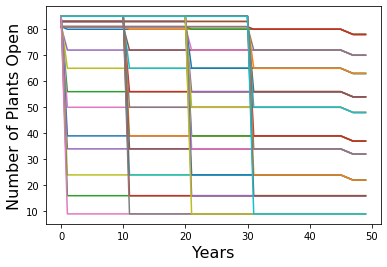

In [128]:
for r in percents[:-1]:
    for y in years:
        plt.plot(num_plants_df[r].loc[y])
plt.xlabel('Years', fontsize = 16)
plt.ylabel('Number of Plants Open', fontsize = 16)
plt.savefig('figures/all_trajectory.pdf', bbox_inches = 'tight', dpi = 350)   

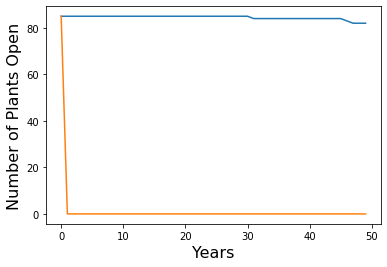

In [110]:
#for year in [10,40]:
    #for r in [10]:
plt.plot(num_plants_df[100].loc[30]+4)
plt.plot(num_plants_df[1].loc[0])

plt.xlabel('Years', fontsize = 16)
plt.ylabel('Number of Plants Open', fontsize = 16)
plt.savefig('figures/ex_plants_trajectory.pdf', bbox_inches = 'tight', dpi = 350)

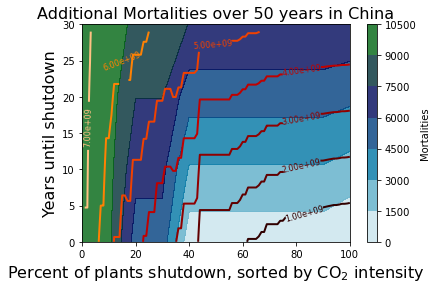

In [98]:
contours = plt.contour(CO2_df.columns, CO2_df.index[:30], CO2_df[:30], cmap = 'gist_heat', linewidths = 2)
plt.clabel(contours, fmt = '%1.2e', fontsize=8, inline = True)
plt.contourf(percents, years, mort_df[:], cmap = 'ocean_r', alpha = .8)
plt.colorbar(label = 'Mortalities')
plt.title('Additional Mortalities over 50 years in China', fontsize = 16)
plt.xlabel(r'Percent of plants shutdown, sorted by CO$_2$ intensity', fontsize = 16)
plt.ylabel('Years until shutdown', fontsize = 16)
#plt.ylim(0,29)
#plt.xlim(30,100)
plt.savefig('figures/china_mort_BC_contours.pdf', bbox_inches = 'tight', dpi = 350)

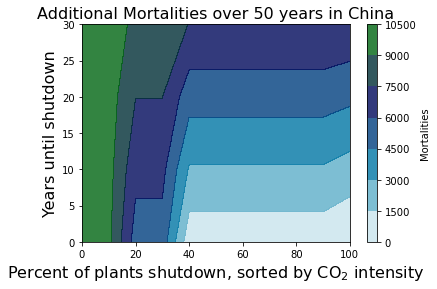

In [134]:
#contours = plt.contour(CO2_df.columns, CO2_df.index[:30], CO2_df[:30], cmap = 'gist_heat', linewidths = 2)
#plt.clabel(contours, fmt = '%1.2e', fontsize=8, inline = True)
plt.contourf(percents, years, mort_df[:], cmap = 'ocean_r', alpha = .8)
plt.colorbar(label = 'Mortalities')
plt.title('Additional Mortalities over 50 years in China', fontsize = 16)
plt.xlabel(r'Percent of plants shutdown, sorted by CO$_2$ intensity', fontsize = 16)
plt.ylabel('Years until shutdown', fontsize = 16)
#plt.ylim(0,29)
#plt.xlim(30,100)
plt.savefig('figures/china_mort_BC_contours_noco2.pdf', bbox_inches = 'tight', dpi = 350)

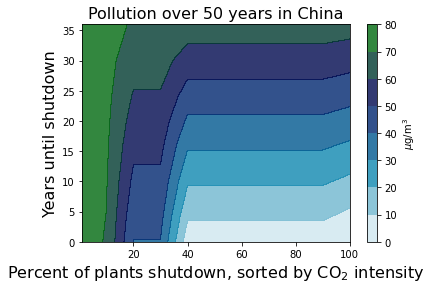

In [133]:
#contours = plt.contour(CO2_df.columns, CO2_df.index[:30], CO2_df[:30], cmap = 'gist_heat', linewidths = 2)
#plt.clabel(contours, fmt = '%1.2e', fontsize=8, inline = True)
plt.contourf(poll_df.columns, poll_df.index, poll_df[:], cmap = 'ocean_r', alpha = .8)
plt.colorbar(label = r'$\mu$g/m$^3$')
plt.title('Pollution over 50 years in China', fontsize = 16)
plt.xlabel(r'Percent of plants shutdown, sorted by CO$_2$ intensity', fontsize = 16)
plt.ylabel('Years until shutdown', fontsize = 16)
#plt.ylim(0,29)
#plt.xlim(30,100)
plt.savefig('figures/china_conc_BC_contours.pdf', bbox_inches = 'tight', dpi = 350)

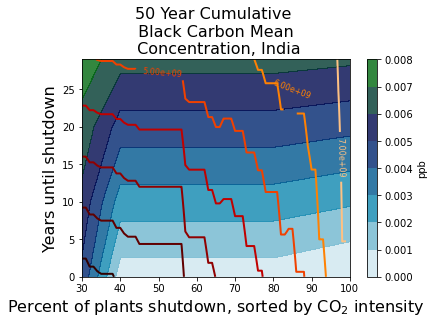

In [368]:
contours = plt.contour(CO2_df[:30], cmap = 'gist_heat', linewidths = 2)
plt.clabel(contours, fmt = '%1.2e', fontsize=8, inline = True)
plt.contourf(percents, years, loc_df['India'].dropna(), cmap = 'ocean_r', alpha = .8)
plt.colorbar(label = 'ppb')
plt.title('50 Year Cumulative \n Black Carbon Mean \n Concentration, India', fontsize = 16)
plt.xlabel(r'Percent of plants shutdown, sorted by CO$_2$ intensity', fontsize = 16)
plt.ylabel('Years until shutdown', fontsize = 16)
plt.ylim(0,29)
plt.xlim(30,100)
plt.savefig('figures/India_sum_BC_contours.pdf', bbox_inches = 'tight', dpi = 350)

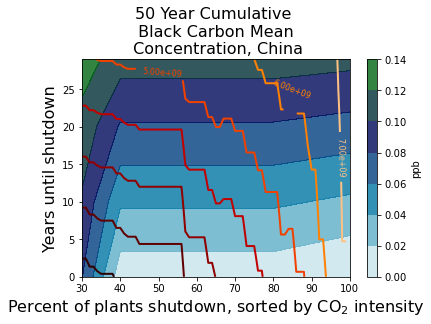

In [369]:
contours = plt.contour(CO2_df[:30], cmap = 'gist_heat', linewidths = 2)
plt.clabel(contours, fmt = '%1.2e', fontsize=8, inline = True)
plt.contourf(percents, years, loc_df['China'].astype('float32').dropna(), cmap = 'ocean_r', alpha = .8)
plt.colorbar(label = 'ppb')
plt.title('50 Year Cumulative \n Black Carbon Mean \n Concentration, China', fontsize = 16)
plt.xlabel(r'Percent of plants shutdown, sorted by CO$_2$ intensity', fontsize = 16)
plt.ylabel('Years until shutdown', fontsize = 16)
plt.ylim(0,29)
plt.xlim(30,100)
plt.savefig('figures/China_sum_BC_contours.pdf', bbox_inches = 'tight', dpi = 350)

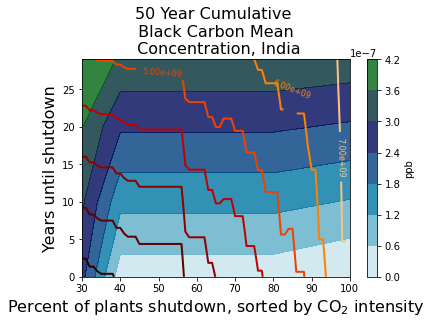

In [370]:
contours = plt.contour(CO2_df[:30], cmap = 'gist_heat', linewidths = 2)
plt.clabel(contours, fmt = '%1.2e', fontsize=8, inline = True)
plt.contourf(percents, years, loc_mean_df['India'].dropna(), cmap = 'ocean_r', alpha = .8)
plt.colorbar(label = 'ppb')
plt.title('50 Year Cumulative \n Black Carbon Mean \n Concentration, India', fontsize = 16)
plt.xlabel(r'Percent of plants shutdown, sorted by CO$_2$ intensity', fontsize = 16)
plt.ylabel('Years until shutdown', fontsize = 16)
plt.ylim(0,29)
plt.xlim(30,100)
plt.savefig('figures/India_mean_BC_contours.pdf', bbox_inches = 'tight', dpi = 350)

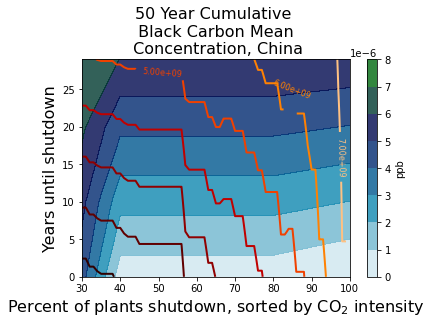

In [371]:
contours = plt.contour(CO2_df[:30], cmap = 'gist_heat', linewidths = 2)
plt.clabel(contours, fmt = '%1.2e', fontsize=8, inline = True)
plt.contourf(percents, years, loc_mean_df['China'].astype('float32').dropna(), cmap = 'ocean_r', alpha = .8)
plt.colorbar(label = 'ppb')
plt.title('50 Year Cumulative \n Black Carbon Mean \n Concentration, China', fontsize = 16)
plt.xlabel(r'Percent of plants shutdown, sorted by CO$_2$ intensity', fontsize = 16)
plt.ylabel('Years until shutdown', fontsize = 16)
plt.ylim(0,29)
plt.xlim(30,100)
plt.savefig('figures/China_mean_BC_contours.pdf', bbox_inches = 'tight', dpi = 350)

## Country/Map Plots

KeyboardInterrupt: 

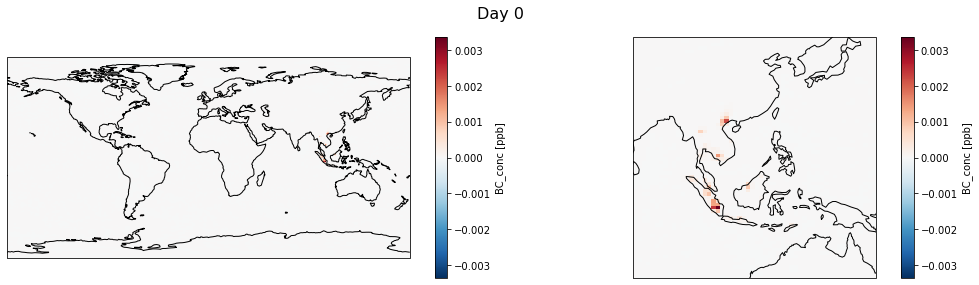

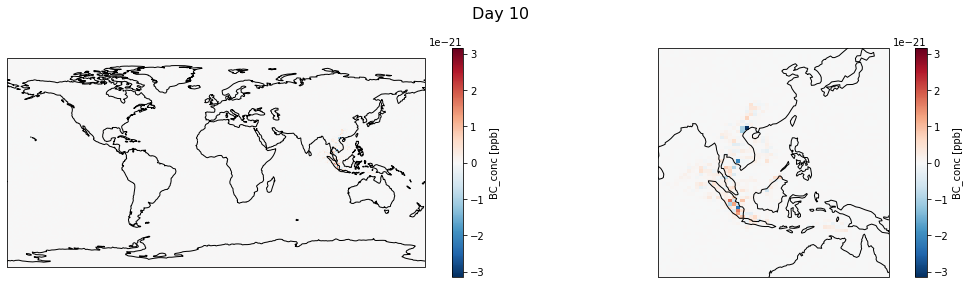

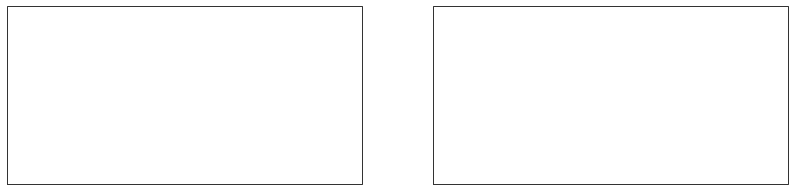

In [319]:
for t in [0,10,20,30]:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.PlateCarree()})
    ##### global view #######
    (ds.sel(year_shutdown = 0, percent = 100)['BC_conc'].isel(s = t*365)).plot(ax = ax1, transform = ccrs.PlateCarree(), 
                                                                                #norm = SymLogNorm(1e-19, 1, -1e-16, 1e-16), add_colorbar = False,
                                                                               cmap = 'RdBu_r')
    ax1.coastlines()
    ax1.set_title('')
    ##### Zoomed in ########
    (ds.sel(year_shutdown = 0, percent = 100)['BC_conc'].isel(s = t*365)).plot(ax = ax2, transform = ccrs.PlateCarree(), 
                                                                               # norm = SymLogNorm(1e-19, 1, -1e-16, 1e-16),
                                                                               cmap = 'RdBu_r')
    ax2.coastlines()
    ax2.add_feature(cfeat.STATES)
    ax2.set_extent([80,150,-20,40])
    ax2.set_title('')
    plt.suptitle(f'Day {t}', fontsize = 16);
    plt.tight_layout()
    #plt.savefig("figures/GF_video/" + str(t).zfill(4) + ".png", dpi = 350, bbox_inches = 'tight')
    #plt.close();

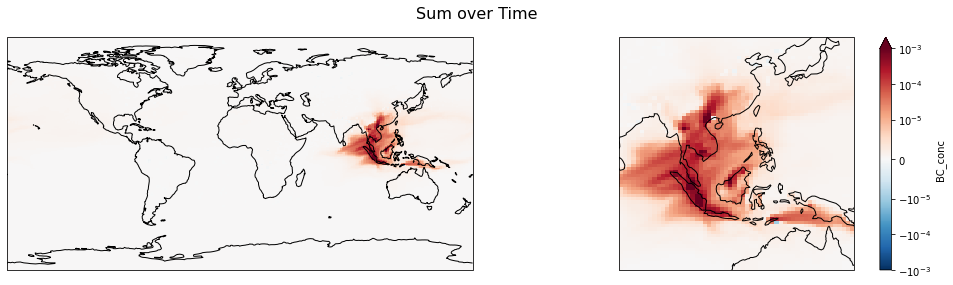

In [321]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.PlateCarree()})
##### global view #######
(ds.sel(year_shutdown = 0, percent = 100)['BC_conc'].sum(dim = 's')).plot(ax = ax1, transform = ccrs.PlateCarree(), 
                                                                            norm = SymLogNorm(1e-5, 1, -1e-3, 1e-3), add_colorbar = False,
                                                                           cmap = 'RdBu_r')
ax1.coastlines()
ax1.set_title('')
##### Zoomed in ########
(ds.sel(year_shutdown = 0, percent = 100)['BC_conc'].sum(dim = 's')).plot(ax = ax2, transform = ccrs.PlateCarree(), 
                                                                            norm = SymLogNorm(1e-5, 1, -1e-3, 1e-3),
                                                                           cmap = 'RdBu_r')
ax2.coastlines()
ax2.add_feature(cfeat.STATES)
ax2.set_extent([80,150,-20,40])
ax2.set_title('')
plt.suptitle(f'Sum over Time', fontsize = 16);
plt.tight_layout()
plt.savefig("figures/0_100_yr_pct.pdf", dpi = 350, bbox_inches = 'tight')
#plt.close();

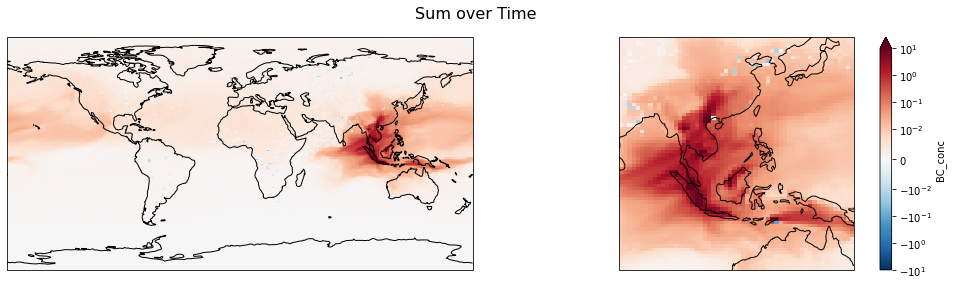

In [ ]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.PlateCarree()})
##### global view #######
(ds.sel(year_shutdown = 30, percent = 30)['BC_conc'].sum(dim = 's')).plot(ax = ax1, transform = ccrs.PlateCarree(), 
                                                                            norm = SymLogNorm(1e-2, 1, -10, 10), add_colorbar = False,
                                                                           cmap = 'RdBu_r')
ax1.coastlines()
ax1.set_title('')
##### Zoomed in ########
(ds.sel(year_shutdown = 30, percent = 30)['BC_conc'].sum(dim = 's')).plot(ax = ax2, transform = ccrs.PlateCarree(), 
                                                                            norm = SymLogNorm(1e-2, 1, -10, 10),
                                                                           cmap = 'RdBu_r')
ax2.coastlines()
ax2.add_feature(cfeat.STATES)
ax2.set_extent([80,150,-20,40])
ax2.set_title('')
plt.suptitle(f'Sum over Time', fontsize = 16);
plt.tight_layout()
plt.savefig("figures/30_30_yr_pct.pdf", dpi = 350, bbox_inches = 'tight')
#plt.close();